In [28]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
import gc
import sys

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import metrics

2021-09-02 08:53:20.336942: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
#data_path='/data/external/PEM/L0162_20200909T0001_20201201T1230.csv'
data_path='/data-restricted/PEM/L0162_20200909T0001_20201201T1230.csv'
data=pd.read_csv(data_path)
data.shape

(66331, 46)

In [6]:
data['DateTime']=pd.to_datetime(data['Timestamp'],format='%d/%m/%Y %H:%M')

In [7]:
data.columns

Index(['Timestamp', 'BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL',
       'F_W2', 'F_WA36', 'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL',
       'T3SEL', 'TFLCYCS', 'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM',
       'WFQPERRCOR', 'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL',
       'PX36BVAL', 'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL',
       'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL', 'NOX_HMI', 'CO_HMI',
       'O2_HMI', 'VLVFBKG_06', 'EMISSIONS_SS', 'SSFILTER', 'F_WB3', 'NOX15',
       'CO15', 'DateTime'],
      dtype='object')

In [8]:
data=data.set_index(data['DateTime'])
data.drop(['NOX15','CO15'],axis=1,inplace=True)
data.shape


(66331, 45)

In [10]:
#data.head() # starts with 20.09.09 00:01:00 ends with 2020-12-01 12:30

array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>],
      dtype=object)

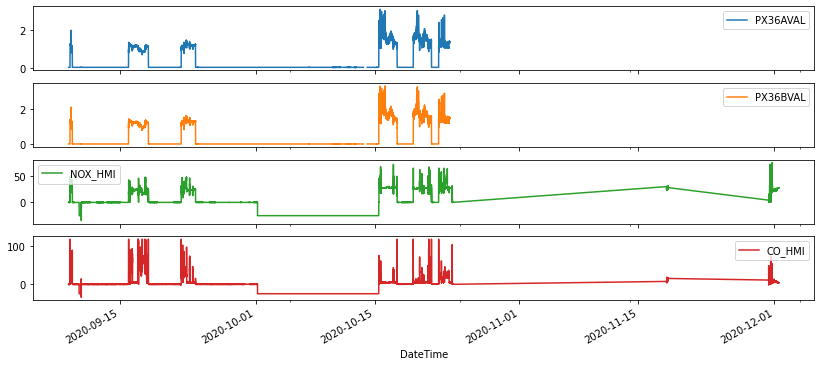

In [9]:
data[['PX36AVAL', 'PX36BVAL','NOX_HMI', 'CO_HMI']].plot(subplots=True,figsize=(14,6))

In [10]:
# this is my second data set
df=data[data['EMISSIONS_SS']==1.0]
print(df.shape)

(8597, 45)


array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>],
      dtype=object)

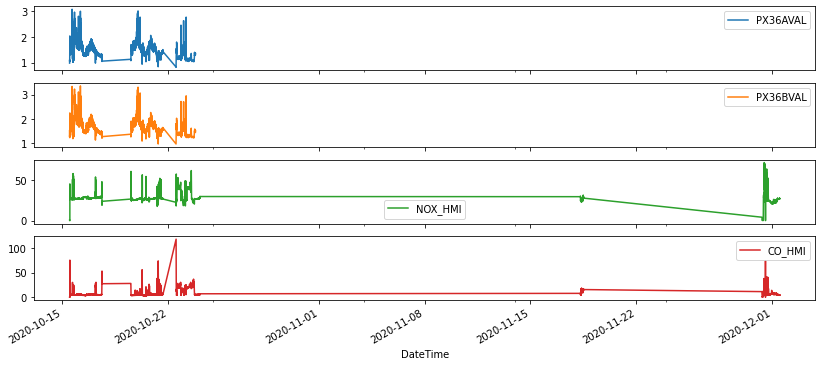

In [11]:
df[['PX36AVAL', 'PX36BVAL','NOX_HMI', 'CO_HMI']].plot(subplots=True,figsize=(14,6))

In [12]:
dff=df.copy()
dff['numbers']=np.arange(1,8598)
dff=dff.asfreq('1Min')
dff.shape

(67737, 46)

In [35]:
#dff.info()

In [13]:
a = dff.numbers.values  # Extract out relevant column from dataframe as array
m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits

In [14]:
print(start,stop)

421 2438


In [15]:
df_sub=dff[421:2438]

In [16]:
df_sub.isnull().sum().any()

False

array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>],
      dtype=object)

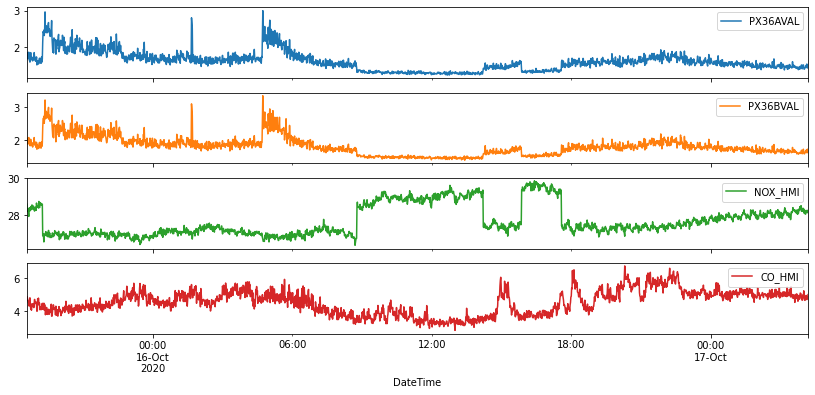

In [17]:
df_sub[['PX36AVAL', 'PX36BVAL','NOX_HMI', 'CO_HMI']].plot(subplots=True,figsize=(14,6))

In [18]:
print(df_sub.DateTime.min(),df_sub.DateTime.max())

2020-10-15 18:35:00 2020-10-17 04:11:00


In [19]:
df_sub.DateTime.max()-df_sub.DateTime.min()

Timedelta('1 days 09:36:00')

In [60]:
1440+(9*60+36)

2016

In [20]:
#df_sub.to_csv('data_modified.csv',index=False)

In [21]:
df=df_sub.copy()
df.shape

(2017, 46)

In [22]:
df.columns

Index(['Timestamp', 'BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL',
       'F_W2', 'F_WA36', 'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL',
       'T3SEL', 'TFLCYCS', 'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM',
       'WFQPERRCOR', 'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL',
       'PX36BVAL', 'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL',
       'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL', 'NOX_HMI', 'CO_HMI',
       'O2_HMI', 'VLVFBKG_06', 'EMISSIONS_SS', 'SSFILTER', 'F_WB3', 'DateTime',
       'numbers'],
      dtype='object')

In [23]:
df.drop(['DateTime','Timestamp'],axis=1,inplace=True)
df.shape

(2017, 44)

In [24]:
split=int(70/100*len(df))
split

1411

In [25]:
train_df,test_df=df[:split],df[split:]
print(train_df.shape,test_df.shape)
OUTPUT_COLUMNS=['NOX_HMI','CO_HMI']
#OUTPUT_COLUMNS=['NOX_HMI']
train_X=train_df.drop(OUTPUT_COLUMNS,axis=1)
train_y=train_df[OUTPUT_COLUMNS]
test_X=test_df.drop(OUTPUT_COLUMNS,axis=1)
test_y=test_df[OUTPUT_COLUMNS]
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(1411, 44) (606, 44)
(1411, 42) (1411, 2) (606, 42) (606, 2)


In [32]:
train_y.head()

,NOX_HMI,CO_HMI
DateTime,,
2020-10-15 18:35:00,28.581451,4.675895
2020-10-15 18:36:00,28.204620,4.864481
2020-10-15 18:37:00,28.257196,4.715476
2020-10-15 18:38:00,28.331768,4.627776
2020-10-15 18:39:00,28.138941,4.513836


In [ ]:
## Models
### 

In [95]:
other_params={'learning_rate':0.1,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}
multioutputregressor=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X,train_y)

predictions=multioutputregressor.predict(test_X)

#for test set
print('Root_mean_squared_error_test set_xgb',math.sqrt(mean_squared_error(test_y,predictions)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions))
print('Root_mean_squared_error_test set_CO_HMI_xgb',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions[:,1])))
print('R2 Score_test set_CO_HMI_xgb',r2_score(test_y['CO_HMI'],predictions[:,1]))

print('Root_mean_squared_error_test set_NOX_xgb',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions[:,0])))
print('R2 Score_test set_NOX_xgb',r2_score(test_y['NOX_HMI'],predictions[:,0]))


Root_mean_squared_error_test set_xgb 0.7178251152228351
R2 Score_test set_xgb -2.506184008395837
Root_mean_squared_error_test set_CO_HMI_xgb 0.8026911679896146
R2 Score_test set_CO_HMI_xgb -2.731580341621949
Root_mean_squared_error_test set_NOX_xgb 0.6214762110658953
R2 Score_test set_NOX_xgb -2.2807876751697256


In [31]:
import math
max_depth = 10
regr_multirf = RandomForestRegressor(n_estimators=300,
                                                         max_depth=max_depth,
                                                          random_state=0)
regr_multirf.fit(train_X, train_y)
predictions_rf=regr_multirf.predict(test_X)

#for test set
print('Root_mean_squared_error_test set_rf',math.sqrt(mean_squared_error(test_y,predictions_rf)))
print('R2 Score_test set_rf',r2_score(test_y,predictions_rf))
print('Root_mean_squared_error_test set_CO_HMI_rf',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions_rf[:,1])))
print('R2 Score_test set_CO_HMI_rf',r2_score(test_y['CO_HMI'],predictions_rf[:,1]))
print('Root_mean_squared_error_test set_NOX_rf',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions_rf[:,0])))
print('R2 Score_test set_NOX_rf',r2_score(test_y['NOX_HMI'],predictions_rf[:,0]))

Root_mean_squared_error_test set_rf 0.5809256375688037
R2 Score_test set_rf -1.1523687396602877
Root_mean_squared_error_test set_CO_HMI_rf 0.5365449641651571
R2 Score_test set_CO_HMI_rf -0.3456485952151862
Root_mean_squared_error_test set_NOX_rf 0.6221484502901634
R2 Score_test set_NOX_rf -1.959088884105387


In [87]:
predictions_rf_train=regr_multirf.predict(train_X)

print('Root_mean_squared_error_test set_rf',math.sqrt(mean_squared_error(train_y,predictions_rf_train)))
print('R2 Score_test set_rf',r2_score(train_y,predictions_rf_train))
print('Root_mean_squared_error_test set_CO_HMI_rf',math.sqrt(mean_squared_error(train_y['CO_HMI'],predictions_rf_train[:,1])))
print('R2 Score_test set_CO_HMI_rf',r2_score(train_y['CO_HMI'],predictions_rf_train[:,1]))
print('Root_mean_squared_error_test set_NOX_rf',math.sqrt(mean_squared_error(train_y['NOX_HMI'],predictions_rf_train[:,0])))
print('R2 Score_test set_NOX_rf',r2_score(train_y['NOX_HMI'],predictions_rf_train[:,0]))

Root_mean_squared_error_test set_rf 0.0811562731647891
R2 Score_test set_rf 0.986094419307302
Root_mean_squared_error_test set_CO_HMI_rf 0.09858604242298677
R2 Score_test set_CO_HMI_rf 0.9759231941071159
Root_mean_squared_error_test set_NOX_rf 0.05876626232260131
R2 Score_test set_NOX_rf 0.996265644507488


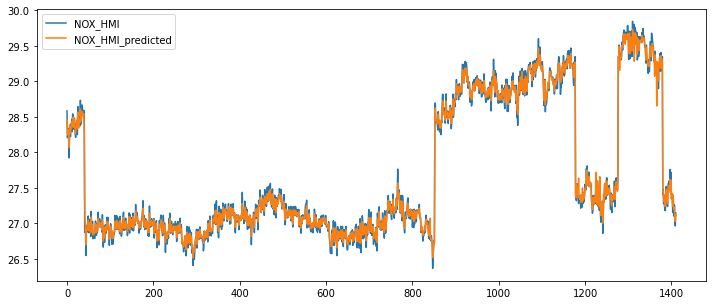

In [91]:
plt.figure(figsize=(12,5))
plt.plot(train_y['NOX_HMI'].values, label='NOX_HMI')
plt.plot(predictions_rf_train[:,0], label='NOX_HMI_predicted')
plt.legend()
plt.show()

In [ ]:
#LSTM